### Notebook for analysing nf pipeline output

#### Sequencing batch 11

### Sequencing information a
 - Analysis no.: A006
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext
 - Loaded: 14pM
 - Seq Date: 04-06-2021
 - Number of samples:96
 - Cluster Density: 263K
 - Passing Filter: 97.7/75.6
 - Output: 2.6G/2.0g
 - Fragment size: 550
 - Lib conc: 3.4
 - Cubit: 1.225
 - Lib load start concentration: 2nM
 - Cycles: 502
 - PhiX: False

Mistake: Having started from a 2nM lib conc a higher concentration of the library needed to be loaded

Sequencing information b¶
 - Analysis no.: A006
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext
 - Loaded: 12pM
 - Seq Date: 07-06-2021
 - Number of samples:95
 - Cluster Density: 510K
 - Passing Filter: 93.3/81
 - Output: 4.9G/3.9G
 - Fragment size: 550
 - Lib conc: 4.3
 - Cubit: 1.55
 - Lib load start concentration: 2nM
 - Cycles: 502
 - PhiX: False

In [2]:
# plot primer depths across samples-GK
import pandas as pd, matplotlib.pyplot as plt, numpy as np, os

suffix = '.amplicon.regions.coverage.tsv'
base_dir = '/home/douso/2021-06-07_run9_con_2021-05-28_run8_corr'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1
fig, axs = plt.subplots(a, b, figsize=(20,120)) 

xtick = np.arange(0, 98)
xlabel = np.arange(1, 99)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    sample_df = pd.read_table(f'{base_dir}/{file}')
    sample_df2 = sample_df[['region', 'coverage']]
    sample_df2.plot(logy=True, ax=axs[c], sharex=True, sharey=False) 
    axs[c].legend([sample_name], loc='lower left')
plt.xlabel('Primer name')
plt.ylabel('Read coverage')
plt.xticks(xtick, xlabel, rotation=45)
plt.tight_layout()
plt.show()
#fig.savesample_df2fig('avg_kit_coverage2.png')


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1440x8640 with 0 Axes>

In [ ]:
# plot read depths-GK
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt
base_dir = '/home/douso/2021-06-07_run9_con_2021-05-28_run8_corr'
suffix = '.genome.regions.coverage.tsv'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1

fig, axs = plt.subplots(a, b, figsize=(20, 60))

xtick = range(0, 30200, 200)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    try:
        df1 = pd.read_table(f'{base_dir}/{file}')
        d = df1['coverage'].to_frame()
        d.set_index(np.arange(0, 30000, 200)).plot(logy=True, ax=axs[c], sharex=True, color='orange')
        axs[c].legend([sample_name], loc='lower left')
        text = file.split('_')[1]
        plt.ylabel('Read coverage')
    except TypeError:
            print(f'no numeric data to plot for {file}')
    finally: pass
plt.xlabel('Genome position')
plt.xticks(xtick, rotation=90)
plt.tight_layout()
plt.show()
#fig.savefig('avg_kit_coverage.png')

## Packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import glob

In [4]:
base_dir = '/home/douso/2021-06-07_run9_con_2021-05-28_run8_corr'
batch = 'seq11'
# dpt_dir = # ivar, samtools-depth output files
# nxt_dir = # nextclade .tsv output file
# png_dir = # pangolin .tsv output file
# var_dir = # snpEff ouput
# rmd_dir = # raw metadata - moh .xlsx spread sheet
#dpt var nxt png

### Sequencing information 
 - Analysis no.: NF-004 (batch 10)
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext
 - Seq Date: MiSeq (28-05-2021)
 - Number of samples: 96
 - Sample summ: COVCs
 - VC pipeline: nextflow-viralcon, v1.0.1

## Functions

In [5]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [6]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [7]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [8]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.set_index('sample_name').merge(df_nxt_cln
          .set_index('seqName'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'sample_name'}))

In [9]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.set_index('Sequence_name').merge(df_varNxt
        .set_index('sample_name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'Sequence_name'}))


In [10]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.set_index('S_NUM').merge(df_cts_cln.set_index('Sample_Name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'S_NUM'}))


In [11]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.set_index('S_NUM')
            .merge(df_rmdCts.set_index('S_NUM'), how='left', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'S_NUM'}))

In [12]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('_')[0]))
    return df_fnl

### Variants data

In [13]:
# import the collated file for all the snpEff outputs
df_var = pd.read_table(f'{base_dir}/var/k-per-gene_variant_anns.tsv')
df_var_fnl = df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: x.split('_')[0]))

In [14]:
df_var_fnl.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVC15079,18,"E102Q, T265I, F924F, E1461E, V3261I, K3353R, L...",NaN,"S375S, D614G, L1200L, Q1201K",Q57H,NaN,NaN,NaN,NaN,NaN,NaN,A14T,"P13S, R195K, P207T",NaN,NaN,N25N
1,COVC12772,15,"T265I, F924F, S944L, P1096L, A2557A, P2685P, L...",NaN,"D614G, V1094V,",Q57H,NaN,NaN,I76I,R20K,E95Q,NaN,NaN,R195K,NaN,NaN,NaN
2,COVC04189,10,"T265I, F924F, V1187I, P1862L, L3234L, L4715L",NaN,"D614G, S1252F",Q57H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN
3,COVC03813,11,"T265I, F924F, T2154I, L4715L, V6472V",NaN,D614G,"T14I, Q57H, L65F",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"R195K, H300Y",NaN,NaN,NaN
4,COVC11834,14,"F924F, T1761I, I1877T, F3444L, T4501S, L4715L,...",NaN,"Q52E, W152L, Y421Y, D614G, T941A,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,T26I,S206F,NaN,NaN,NaN


### Nextclade data

In [15]:
# import Nextclade clade data
df_nxt = pd.read_table(f'{base_dir}/nxt/nxt.tsv')

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: x.split('_')[0]))
df_nxt_fnl = df_nxt_cln1.assign(coverage = coverage).drop('totalMissing', axis=1)

In [16]:
df_nxt_fnl.head()

,seqName,clade,coverage
0,COVC03617,20C,98.6
1,COVC03665,20C,97.5
2,COVC03696,20C,98.5
3,COVC03723,20C,99.2
4,COVC03813,20C,98.6


### Pangolin data v.3.0.5 (05-06-2021) Ran: 13-06-2021

In [17]:
# import Pangolin lineage data
df_png = pd.read_csv(f'{base_dir}/png/png.csv', header=0)
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Scorpio_call']#, 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_fnl = df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: x.split('_')[0]))
# df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months) if (isinstance(x, str)) else x))

In [18]:
df_png_fnl.head()

,Sequence_name,Lineage,Scorpio_call
0,COVC03617,B.1,NaN
1,COVC03665,B.1,NaN
2,COVC03696,B.1,NaN
3,COVC03723,B.1,NaN
4,COVC03813,B.1,NaN


# Metadata

In [19]:
# import raw metadata file
import pandas as pd
mbase_dir = '/home/douso/Documents/TrendData/Results/ResultsMerged'
df_rmd_cln = pd.read_excel(f'{mbase_dir}/COVID19-results-merged-cln.xlsx')

In [20]:
df_rmd_cln.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF
0,COVC00001,35.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020
1,COVC00002,29.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020
2,COVC00003,50.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020
3,COVC00004,35.0,F,Casual,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020
4,COVC00005,27.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020


### Ct data

In [21]:
# import Ct data from sheet2 of the metadata file
ctbase_dir = '/home/douso/Documents/RunSheets/Cts'
df_cts = pd.read_excel(f'{ctbase_dir}/runsheet-cts.xlsx')

In [22]:
df_cts.head()

,Sample_Name,Ct_Mean
0,COVC00137,37.6
1,COVC00154,35.2
2,COVC00744,34.7
3,COVC00762,36.0
4,COVC00767,34.1


### Combining data

#### Merge Variants and Nextclade data

In [23]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [24]:
df_varNxt.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC03617,15,"T265I, N430S, F924F, P1330P, A2355S, A2584V, I...",NaN,D614G,"Q57H, S253S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN,20C,98.6
1,COVC03665,16,"T265I, N430S, F924F, P1330P, A2355S, A2584V, I...",NaN,"A263S, D614G","Q57H, S253S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN,20C,97.5
2,COVC03696,13,"T265I, F924F, L3606F, L4715L, F4730Y, M5383T, ...",NaN,D614G,"S26P, Q57H",NaN,NaN,NaN,W27L,NaN,NaN,F3S,R195K,NaN,NaN,NaN,20C,98.5
3,COVC03723,9,"T265I, F924F, L4715L",NaN,D614G,"S26P, Q57H",NaN,NaN,G147G,NaN,NaN,NaN,F3S,R195K,NaN,NaN,NaN,20C,99.2
4,COVC03813,11,"T265I, F924F, T2154I, L4715L, V6472V",NaN,D614G,"T14I, Q57H, L65F",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"R195K, H300Y",NaN,NaN,NaN,20C,98.6


#### Merge pango and var-nextclade data

In [25]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [26]:
df_pngVxt.head()

,Sequence_name,Lineage,Scorpio_call,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,...,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC03617,B.1,NaN,15.0,"T265I, N430S, F924F, P1330P, A2355S, A2584V, I...",NaN,D614G,"Q57H, S253S",NaN,NaN,...,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN,20C,98.6
1,COVC03665,B.1,NaN,16.0,"T265I, N430S, F924F, P1330P, A2355S, A2584V, I...",NaN,"A263S, D614G","Q57H, S253S",NaN,NaN,...,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN,20C,97.5
2,COVC03696,B.1,NaN,13.0,"T265I, F924F, L3606F, L4715L, F4730Y, M5383T, ...",NaN,D614G,"S26P, Q57H",NaN,NaN,...,W27L,NaN,NaN,F3S,R195K,NaN,NaN,NaN,20C,98.5
3,COVC03723,B.1,NaN,9.0,"T265I, F924F, L4715L",NaN,D614G,"S26P, Q57H",NaN,NaN,...,NaN,NaN,NaN,F3S,R195K,NaN,NaN,NaN,20C,99.2
4,COVC03813,B.1,NaN,11.0,"T265I, F924F, T2154I, L4715L, V6472V",NaN,D614G,"T14I, Q57H, L65F",NaN,NaN,...,NaN,NaN,NaN,NaN,"R195K, H300Y",NaN,NaN,NaN,20C,98.6


In [27]:
df_pngVxt_cols = ['Sequence_name', 'Lineage', 'Scorpio call',
       'num_vars', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'clade',
       'coverage']
df_pngVxt_cols_rename = ['S_NUM', 'LIN', 'SCORP_CALL',
       'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'CLADE',
       'G_COV']
df_pngVxt.columns = df_pngVxt_cols_rename

#### Merge the metadata and Cts data

In [28]:
# merge metadata with cts data
df_rmdCts = merge_rmdCts(df_rmd_cln, df_cts).rename(columns={'Ct_Mean': 'AVG_Ct'})

In [29]:
df_rmdCts.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF,AVG_Ct
0,COVC00001,35.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020,NaN
1,COVC00002,29.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020,NaN
2,COVC00003,50.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020,NaN
3,COVC00004,35.0,F,Casual,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020,NaN
4,COVC00005,27.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020,NaN


#### Merge sequence/var-nxt-png (pngVxt) and  processed metadata (rmdCts)

In [30]:
# merge processed metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmdCts)

In [31]:
df_vnpPmd.columns#shape#head()

Index(['S_NUM', 'LIN', 'SCORP_CALL', 'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a',
       'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a',
       'ORF9b', 'ORF10', 'CLADE', 'G_COV', 'AGE_YRS', 'GEND', 'OCCU', 'NAT',
       'COUNT_RES', 'S_COUNT_RES', 'TRAV_HIST', 'TRAV_FROM', 'QUAR_PLACE',
       'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 'DT_CONF', 'AVG_Ct'],
      dtype='object')

#### QC whether all samples sequenced had metadata

In [32]:
codes_fnl = set(df_vnpPmd['S_NUM'])
codes_metadata = set(df_rmdCts['S_NUM'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

The following samples may be lacking pre-seq metadata, please verify:
{'MN908947.3'}


#### Re-order df_vnpPmd columns and export merged metadata and sequencing data

In [33]:
header_MS = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'LIN', 'SCORP_CALL', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [34]:
header_policy = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct']

In [35]:
df_vnpPmd.head()

,S_NUM,LIN,SCORP_CALL,N_VAR,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,...,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF,AVG_Ct
0,COVC03617,B.1,NaN,15.0,"T265I, N430S, F924F, P1330P, A2355S, A2584V, I...",NaN,D614G,"Q57H, S253S",NaN,NaN,...,Embakasi,No,NaN,DSH,None,06-07-2020,NaN,Positive,08-07-2020,17.5
1,COVC03665,B.1,NaN,16.0,"T265I, N430S, F924F, P1330P, A2355S, A2584V, I...",NaN,"A263S, D614G","Q57H, S253S",NaN,NaN,...,Embakasi,No,NaN,DSH,None,06-07-2020,NaN,Positive,08-07-2020,22.4
2,COVC03696,B.1,NaN,13.0,"T265I, F924F, L3606F, L4715L, F4730Y, M5383T, ...",NaN,D614G,"S26P, Q57H",NaN,NaN,...,Embakasi,No,NaN,DSH,None,06-07-2020,NaN,Positive,08-07-2020,20.8
3,COVC03723,B.1,NaN,9.0,"T265I, F924F, L4715L",NaN,D614G,"S26P, Q57H",NaN,NaN,...,Ruaraka,No,NaN,DSH,None,06-07-2020,NaN,Positive,08-07-2020,21.6
4,COVC03813,B.1,NaN,11.0,"T265I, F924F, T2154I, L4715L, V6472V",NaN,D614G,"T14I, Q57H, L65F",NaN,NaN,...,Embakasi central,No,NaN,Hemingways,No,10-07-2020,NaN,Positive,13-07-2020,16.0


In [36]:
df_vnpPmd_fnl = df_vnpPmd[header_policy]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel('/home/douso/SarsGenomics/Processed/policy-brief-M006-corr.xlsx'
                     , index=False, na_rep='N/A', float_format='%.1f'))

In [37]:
df_vnpPmd_fnl = df_vnpPmd[header_MS]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel('/home/douso/SarsGenomics/Processed/metadata-seq-MS006-corr.xlsx'
                     , index=False, na_rep='NA', float_format='%.1f'))
df_vnpPmd_fnl.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,...,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVC03617,55.0,F,None indicated,Kenya,Nairobi,No,NaN,DSH,None,...,NaN,NaN,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN
1,COVC03665,23.0,M,None indicated,Kenya,Nairobi,No,NaN,DSH,None,...,NaN,NaN,NaN,NaN,NaN,NaN,R195K,NaN,NaN,NaN
2,COVC03696,24.0,M,None indicated,Kenya,Nairobi,No,NaN,DSH,None,...,NaN,NaN,W27L,NaN,NaN,F3S,R195K,NaN,NaN,NaN
3,COVC03723,36.0,M,None indicated,Kenya,Nairobi,No,NaN,DSH,None,...,NaN,G147G,NaN,NaN,NaN,F3S,R195K,NaN,NaN,NaN
4,COVC03813,59.0,M,NaN,Kenya,Nairobi,No,NaN,Hemingways,No,...,NaN,NaN,NaN,NaN,NaN,NaN,"R195K, H300Y",NaN,NaN,NaN


### Variants of Concern or under investigation
 - N501Y (B.1.1.7): UK variant
 - N501Y, E484K, *K417N (B.1.351): SA variant
 - N501Y, E484K (P.1): Brazilian variant
 - P681R, E484Q, L452R (B.1.617): *Indian variant

In [38]:
# MOH mutations of concern (spike only)
moc_list = ['N501Y', 'E484K', 'K417N', 'P681R', 'E484Q', 'L452R', 'A570D', 'D80A']
file_name = df_var_fnl
df_moc = get_mut_of_concern(file_name, moc_list)

In [39]:
df_moc.head()

,Sample_ID,Mut_of_Concern_(S),All_Mutations_(S)
0,NHRL-S028,A570D,"D138H, Y145del, A570D, D614G, S982A, D1118H, G..."
1,COVC23498,"A570D, N501Y","Y145del, N501Y, A570D, D614G, T716I, S982A"
2,NHRL-S029,"A570D, N501Y","D138H, Y145del, F490S, N501Y, A570D, D614G, P6..."
3,NHRL-S008,A570D,"D138H, Y145del, A570D, D614G, S982A, D1118H, G..."
4,COVC23641,A570D,"D138H, Y145del, A570D, D614G, S982A, D1118H"


### Subsample brief data

In [40]:
#reorder columns and shrink data
cols = ['S_NUM', 'G_COV', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'LIN', 'CLADE', 'SCORP_CALL', 'COUNT_RES'
        , 'GEND', 'NAT']

### Filter reporting coverage

In [41]:
samples = [
    'COVC14709',
'COVC14832',
'COVC15036',
'COVC15278',
'COVC15313',
'COVC15422',
'COVC23637',
'COVC23670',
'COVC23715',
'NHRL-S002',
'NHRL-S003',
'NHRL-S005',
'NHRL-S008',
'NHRL-S020',
'NHRL-S028',
'NHRL-S029',
'NHRL-S032',
'NHRL-S037']


In [42]:
df_brief = df_vnpPmd[cols][df_vnpPmd[cols]['S_NUM'].isin(samples)]

In [43]:
# df_brief = df_vnpPmd[cols][df_vnpPmd[cols]['G_COV'] >= 76.4]

In [44]:
df_brief.head()

,S_NUM,G_COV,DT_SAM_COLL,DT_SAM_RECEP,LIN,CLADE,SCORP_CALL,COUNT_RES,GEND,NAT
87,COVC14709,92.2,NaN,19-10-2020,B.1,20A,NaN,Nairobi,M,Kenya
89,COVC14832,99.1,19-10-2020,19-10-2020,B.1,20C,NaN,Kiambu,M,Kenya
93,COVC15036,92.9,21-10-2020,23-10-2020,B.1,20C,NaN,Kiambu,M,Kenya
100,COVC15278,96.2,24-10-2020,24-10-2020,B.1.214,20A,NaN,Kiambu,F,Kenya
102,COVC15313,90.6,19-10-2020,22-10-2020,B.1,20C,NaN,Mombasa,F,Kenya


#### Merge df_brief with df_moc

In [45]:
df_brfMoc = (df_brief.merge(df_moc, how='left', left_on='S_NUM', right_on='Sample_ID'))
df_brfMoc_fnl = (df_brfMoc.fillna('N/A')
                 .loc[df_brfMoc['S_NUM'] != 'Undetermined']# removes "undetermined"
                 .drop(['Sample_ID', 'All_Mutations_(S)'], axis=1)
                 .drop_duplicates('S_NUM', ignore_index=True))

### Policy brief report

#### Rename report columns

In [46]:
cols = ['Sequence Name', 'coverage', 'Date Collection (dd-mm-yyyy)', 'Date Received (dd-mm-yyyy)', 'Pango Lineage Annotation', 'Next Clade Lineage Annotation', 'WHO Annotation','Sample County of Origin', 'Gender', 'Subject Country of Origin', 'MoC-S-Protein']
df_brfMoc_fnl.columns = cols

In [47]:
df_brfMoc_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC14709,92.2,N/A,19-10-2020,B.1,20A,N/A,Nairobi,M,Kenya,N/A
1,COVC14832,99.1,19-10-2020,19-10-2020,B.1,20C,N/A,Kiambu,M,Kenya,N/A
2,COVC15036,92.9,21-10-2020,23-10-2020,B.1,20C,N/A,Kiambu,M,Kenya,N/A
3,COVC15278,96.2,24-10-2020,24-10-2020,B.1.214,20A,N/A,Kiambu,F,Kenya,N/A
4,COVC15313,90.6,19-10-2020,22-10-2020,B.1,20C,N/A,Mombasa,F,Kenya,N/A


In [48]:
df_brfMoc_fnl[df_brfMoc_fnl['Sequence Name'].isin(['COVC06200']) == True]

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein


In [49]:
def format_dates(x):
    if isinstance(x, pd.Timestamp):
        return x#x = x.strftime(format='%d-%m-%Y')
    return x
    

In [50]:
import numpy as np
df_brfMoc_fnl['Date Collection (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Collection (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [51]:
import numpy as np
df_brfMoc_fnl['Date Received (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Received (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [52]:
df_brfMoc_fnl[df_brfMoc_fnl['Sequence Name'].isin(['COVC12767']) == True]

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein


In [53]:
df_report_fnl = df_brfMoc_fnl

In [54]:
df_report_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC14709,92.2,NaT,2020-10-19,B.1,20A,N/A,Nairobi,M,Kenya,N/A
1,COVC14832,99.1,2020-10-19,2020-10-19,B.1,20C,N/A,Kiambu,M,Kenya,N/A
2,COVC15036,92.9,2020-10-21,2020-10-23,B.1,20C,N/A,Kiambu,M,Kenya,N/A
3,COVC15278,96.2,2020-10-24,2020-10-24,B.1.214,20A,N/A,Kiambu,F,Kenya,N/A
4,COVC15313,90.6,2020-10-19,2020-10-22,B.1,20C,N/A,Mombasa,F,Kenya,N/A


In [55]:
df_report_fnl.to_excel('/home/douso/SarsGenomics/Processed/policy-brief-T006-corr.xlsx'
                     , index=False, na_rep='N/A', float_format='%.1f')

In [56]:
#clrs = pd.read_html('https://www.rapidtables.com/web/css/css-color.html')

In [57]:
df_report_fnl.sort_values('Date Collection (dd-mm-yyyy)')#.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
1,COVC14832,99.1,2020-10-19,2020-10-19,B.1,20C,N/A,Kiambu,M,Kenya,N/A
4,COVC15313,90.6,2020-10-19,2020-10-22,B.1,20C,N/A,Mombasa,F,Kenya,N/A
2,COVC15036,92.9,2020-10-21,2020-10-23,B.1,20C,N/A,Kiambu,M,Kenya,N/A
5,COVC15422,91.6,2020-10-22,2020-10-24,B.1,20C,N/A,Laikipia,M,Kenya,N/A
3,COVC15278,96.2,2020-10-24,2020-10-24,B.1.214,20A,N/A,Kiambu,F,Kenya,N/A
13,NHRL-S020,92.1,2021-03-16,NaT,B.1.1.7,20I/501Y.V1,Alpha (B.1.1.7-like),Mombasa,M,Kenya,A570D
14,NHRL-S028,90.1,2021-03-16,NaT,B.1.1.7,20I/501Y.V1,Alpha (B.1.1.7-like),Kiambu,F,Kenya,A570D
15,NHRL-S029,93.8,2021-03-16,NaT,B.1.1.7,20I/501Y.V1,Alpha (B.1.1.7-like),Kiambu,M,Kenya,"A570D, N501Y"
7,COVC23670,91.2,2021-03-23,2021-03-24,B.1.1.7,20I/501Y.V1,Alpha (B.1.1.7-like),Nairobi,M,Kenya,A570D
8,COVC23715,92.4,2021-03-25,2021-03-25,B.1.1.7,20I/501Y.V1,Alpha (B.1.1.7-like),Nairobi,M,Kenya,A570D


In [58]:
(df_report_fnl['Sample County of Origin']
 .value_counts())

Nairobi        7
Kiambu         6
Uasin gishu    2
Mombasa        2
Laikipia       1
Name: Sample County of Origin, dtype: int64

In [59]:
clr_code = {'A.23': ('lime', '#00FF00'),
 'A.23.1': ('gray', '#808080'),
 'A.25': ('orangered', '#FF4500'),
 'B.1': ('cyan', '#00FFFF'),
 'B.1.1': ('chocolate', '#D2691E'),
 'B.1.1.171': ('teal', '#008080'),
 'B.1.1.406': ('slategray', '#708090'),
 'B.1.1.7': ('orange', '#FFA500'),
 'B.1.143': ('olive', '#808000'),
 'B.1.214': ('gold', '#8FBC8F'),
 'B.1.276': ('aquamarine', '#006400'),
 'B.1.336': ('tan', '#D2B48C'),
 'B.1.343': ('indigo', '#4B0082'),
 'B.1.349': ('mediumpurple', '#9370DB'),
 'B.1.351': ('blue', '#0000FF'),
 'B.1.388': ('sienna', '#A0522D'),
 'B.1.429': ('khaki', '#F0E68C'),
 'B.1.446': ('palevioletred', '#DB7093'),
 'B.1.517': ('yellow', '#FFFF00'),
 'B.1.525': ('green', '#008000'),
 'B.1.530': ('red', '#AFEEEE'),
 'B.1.549': ('brown', '#A52A2A'),
 'B.1.596.1': ('magenta', '#FF00FF'),
 'B.1.605': ('rosybrown', '#BC8F8F'),
 'B.1.617.2': ('paleturquoise', '#FF0000'),
 'TBA5': ('darkkhaki', '#BDB76B'),
 'TBA6': ('darkgreen', '#7FFFD4'),
 'TBA7': ('yellowgreen', '#9ACD32'),
 'TBA8': ('darkseagreen', '#FFD700'),
 'TBA9': ('seagreen', '#2E8B57')}#BLUES NEXT B.1.361
avail_clr = ['TBA5', 'TBA6', 'TBA7', 'TBA8', 'TBA9']

In [60]:
grpby_lins = (df_report_fnl.groupby('Pango Lineage Annotation')
        .count().sort_values('coverage', ascending=False))

In [61]:
max_count = grpby_lins['Sequence Name'].max()

In [62]:
clr_code_keys = list(clr_code.keys())

In [63]:
lins = list(grpby_lins.index)

In [64]:
lin_tba =  set(lins) - set(clr_code_keys)
lin_tba

set()

In [65]:
import pprint
for lin, clr in zip(lin_tba, avail_clr):
    clr_code[lin] = clr_code.pop(clr)
    avail_clr.remove(clr)

In [66]:
pprint.pprint(clr_code)
pprint.pprint(avail_clr)

{'A.23': ('lime', '#00FF00'),
 'A.23.1': ('gray', '#808080'),
 'A.25': ('orangered', '#FF4500'),
 'B.1': ('cyan', '#00FFFF'),
 'B.1.1': ('chocolate', '#D2691E'),
 'B.1.1.171': ('teal', '#008080'),
 'B.1.1.406': ('slategray', '#708090'),
 'B.1.1.7': ('orange', '#FFA500'),
 'B.1.143': ('olive', '#808000'),
 'B.1.214': ('gold', '#8FBC8F'),
 'B.1.276': ('aquamarine', '#006400'),
 'B.1.336': ('tan', '#D2B48C'),
 'B.1.343': ('indigo', '#4B0082'),
 'B.1.349': ('mediumpurple', '#9370DB'),
 'B.1.351': ('blue', '#0000FF'),
 'B.1.388': ('sienna', '#A0522D'),
 'B.1.429': ('khaki', '#F0E68C'),
 'B.1.446': ('palevioletred', '#DB7093'),
 'B.1.517': ('yellow', '#FFFF00'),
 'B.1.525': ('green', '#008000'),
 'B.1.530': ('red', '#AFEEEE'),
 'B.1.549': ('brown', '#A52A2A'),
 'B.1.596.1': ('magenta', '#FF00FF'),
 'B.1.605': ('rosybrown', '#BC8F8F'),
 'B.1.617.2': ('paleturquoise', '#FF0000'),
 'TBA5': ('darkkhaki', '#BDB76B'),
 'TBA6': ('darkgreen', '#7FFFD4'),
 'TBA7': ('yellowgreen', '#9ACD32'),
 'TBA8':

In [67]:
clr_code

{'A.23': ('lime', '#00FF00'),
 'A.23.1': ('gray', '#808080'),
 'A.25': ('orangered', '#FF4500'),
 'B.1': ('cyan', '#00FFFF'),
 'B.1.1': ('chocolate', '#D2691E'),
 'B.1.1.171': ('teal', '#008080'),
 'B.1.1.406': ('slategray', '#708090'),
 'B.1.1.7': ('orange', '#FFA500'),
 'B.1.143': ('olive', '#808000'),
 'B.1.214': ('gold', '#8FBC8F'),
 'B.1.276': ('aquamarine', '#006400'),
 'B.1.336': ('tan', '#D2B48C'),
 'B.1.343': ('indigo', '#4B0082'),
 'B.1.349': ('mediumpurple', '#9370DB'),
 'B.1.351': ('blue', '#0000FF'),
 'B.1.388': ('sienna', '#A0522D'),
 'B.1.429': ('khaki', '#F0E68C'),
 'B.1.446': ('palevioletred', '#DB7093'),
 'B.1.517': ('yellow', '#FFFF00'),
 'B.1.525': ('green', '#008000'),
 'B.1.530': ('red', '#AFEEEE'),
 'B.1.549': ('brown', '#A52A2A'),
 'B.1.596.1': ('magenta', '#FF00FF'),
 'B.1.605': ('rosybrown', '#BC8F8F'),
 'B.1.617.2': ('paleturquoise', '#FF0000'),
 'TBA5': ('darkkhaki', '#BDB76B'),
 'TBA6': ('darkgreen', '#7FFFD4'),
 'TBA7': ('yellowgreen', '#9ACD32'),
 'TBA8':

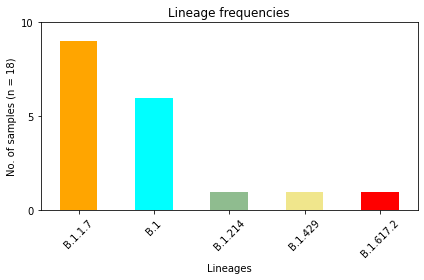

In [68]:
import math
# plot lineage frequencies
colors = [clr_code[lin][1] for lin in lins]
n = df_report_fnl['Pango Lineage Annotation'].count()
yticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots()
(df_report_fnl['Pango Lineage Annotation']
 .value_counts()
 .plot(kind='bar', ax=ax, color=colors))
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.yticks(yticks)
plt.xticks(rotation=45)
plt.ylabel(f'No. of samples (n = {n})')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P006-corr.png', dpi=300.0)
plt.show()